# Numerical computational project
In the following project, there are two proposals for the numerical evaluation of the Black and Scholes solution of a put option:

1. First proposal is the **Implicit Euler Method**  
2. Second proposal is the **Theta Method**  (Crank-Nicholson $\theta = \frac{1}{2}$)

For a **Digital put**:

$$
\varphi(S) = \mathbb{1}_{S<K}
$$


with asset modelazied as **GMB**:

$$
dS = rSdt + \sigma S dW_t
$$


In [52]:
#Library
import math as mt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [53]:
#Parameters
r = 0.1/100             #risk-free rate
sigma = 0.4             #Asset Volatility
S0 = 1                  #Asset value
k = 1                   #Strike
T = 2                   #Maturity
flagPUT = 0             #Logical flag for a PUT option

M = [20,150,300,700]  #Time grid steps best 700-800
N = [10,100,200,800]     #Asset Grid steps best 200

In [54]:
#Time grid
dt = [T/M[i] for i in range(len(M))]

#Asset Grid
L = S0*mt.exp((r+sigma**2/2)*T-6*sigma*mt.sqrt(T))      #Lower bounds of Asset Grid
U = S0*mt.exp((r+sigma**2/2)*T+6*sigma*mt.sqrt(T))      #Upper bounds of Asset Grid
dS = [(U-L)/N[i] for i in range(len(N))] 

#Inizialization of Asset vector for different grids
S_n1 = np.zeros((N[0]+1,1))
S_n2 = np.zeros((N[1]+1,1))
S_n3 = np.zeros((N[2]+1,1))
S_n4 = np.zeros((N[3]+1,1))

#Asset matrix
S_ = [S_n1,S_n2,S_n3,S_n4] 

#Asset grid compilation (payoff value)
for j in range(len(N)):
  for i in range(0,N[j]+1):
    S_[j][i] = L+i*dS[j]

#Inizialization of Option vector for different grids 
D_n1 = np.zeros((N[0]+1,1))
D_n2 = np.zeros((N[1]+1,1))
D_n3 = np.zeros((N[2]+1,1))
D_n4 = np.zeros((N[3]+1,1))

#Option matrix
D_ = [D_n1,D_n2,D_n3,D_n4]

#Option grid evaluation (payoff value)
for j in range(len(N)):
  for i in range(0,N[j]+1):
    if flagPUT == 0:
      if S_[j][i]<k:
        D_[j][i]= 1 
    else:
      if S_[j][i]>k:
          D_[j][i] = 1


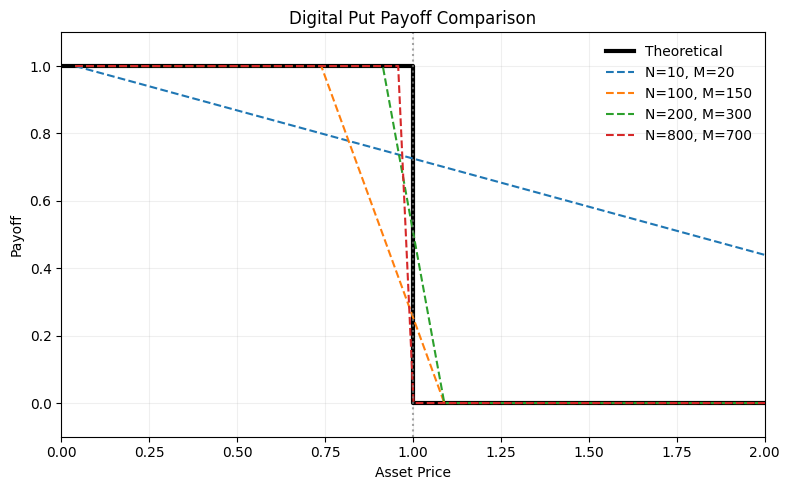

In [55]:
plt.figure(figsize=(8, 5))

#Theoretical line
plt.plot([0, k, k, 2*k], [1, 1, 0, 0], 'k-', linewidth=3, label='Theoretical')

for i in range(len(N)):
    plt.plot(S_[i], D_[i], '--', linewidth=1.5,label=f'N={N[i]}, M={M[i]}')

plt.axvline(k, color='grey', linestyle=':', alpha=0.7)
plt.title('Digital Put Payoff Comparison')
plt.xlabel('Asset Price')
plt.ylabel('Payoff')
plt.xlim(0, 2)
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper right', frameon=False)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

### Function: `solver`

This function solves the linear system $ A x = b $, where `A` is a tridiagonal matrix of size $(N+1) \times (N+1)$, using an iterative method. The initial guess for the solution is provided by `xg`.

- **Inputs**:
  - `A`: Tridiagonal matrix of size $(N+1) \times (N+1)$
  - `b`: Right-hand side vector of size $(N+1) \times 1$
  - `N`: Number of intervals (or subdomains)
  - `xg`: Initial guess for the solution

- **Outputs**:
  - `x`: Approximate solution of the system

- **Algorithm**:
  - Iteratively updates the solution `x` using a Gauss-Seidel-like method.
  - Convergence is checked using the infinity norm $ ||x - xg||_{\infty} < 10^{-6} $.
  - The iteration stops when the solution converges or after `1000` iterations.

In [56]:
def solver(A,b,N,xg):
    x=np.zeros( (N+1,1) )
    maxiter= 1000
    tol=10**(-6)
    for k in range(0,maxiter):
      x[0,0]=(b[0,0]-A[0,1]*xg[1,0])/A[0,0]
      for i in range(1,N):
         x[i,0]=(b[i,0]-A[i,i-1]*x[i-1,0]-A[i,i+1]*xg[i+1,0])/A[i,i]
      x[N,0]=(b[N,0]-A[N,N-1]*x[N-1,0])/A[N,N]
      if np.linalg.norm(x-xg,np.inf)<tol:
          break
      for i in range(0,N+1):
         xg[i,0]=x[i,0]
    return x

### Function: `EU_I_multi_t`

This function implements the **Implicit Euler Method** to solve the Black-Scholes partial differential equation (PDE) for European options.

- **Inputs**:
  - `M`: Number of time steps.
  - `N`: Number of spatial steps for the underlying asset price.
  - `S`: Array of discretized asset prices.
  - `D`: Array representing the initial condition (payoff) at maturity.
  - `r`: Risk-free interest rate.
  - `dS`: Step size in the asset price grid.
  - `sigma`: Volatility of the underlying asset.
  - `dt`: Time step size.
  - `flagPUT`: Option type indicator (0 for Call, 1 for Put).

- **Outputs**:
  - `D`: Option value array at each spatial step, representing the option price at $ t = 0 $.

- **Matrix Structure**:
  The function constructs the tridiagonal matrix $ A $ (denoted as `mA_EI`) with dimensions $(N+1) \times (N+1)$, used in the Implicit Euler scheme:

$$ A = 
\begin{bmatrix} 
1      & 0      & 0      & \ldots & 0      \\ 
a_1    & b_1    & c_1    & \ldots & 0      \\ 
0      & a_2    & b_2    & c_2    & \ldots \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
0      & \ldots & 0      & 0      & 1 
\end{bmatrix}
$$

  - Sub-diagonal $ a_i = -\frac{r S_i}{2 dS} + \frac{\sigma^2 S_i^2}{2 dS^2} $
  - Diagonal $ b_i = -\frac{1}{dt} - \frac{\sigma^2 S_i^2}{dS^2} - r $
  - Super-diagonal $ c_i = \frac{r S_i}{2 dS} + \frac{\sigma^2 S_i^2}{2 dS^2} $
  - Boundary conditions:
    - $ A[0, 0] = 1 $ and $ A[N, N] = 1 $, ensuring Dirichlet boundary conditions at the extremes.

- **Algorithm**:
  - The time-stepping loop proceeds backward from maturity $ T $ to the present time $ t = 0 $, solving $ A D^{j-1} = D^j $ at each step, where $ D^j $ is the option value at time $ t_j $.
  - Boundary conditions are applied at each step according to the option type (`flagPUT`):
    - **Call Option**: $ BC0 = e^{-r(T-t)} $, $ BCN = 0 $.
    - **Put Option**: $ BC0 = 0 $, $ BCN = e^{-r(T-t)} $.
  - The `solver()` function is used to efficiently solve the tridiagonal system at each step.

In [57]:
def EU_I_multi_t(M,N,S,D,r,dS,sigma,dt,flagPUT=0):
    mA_EI = np.zeros((N+1,N+1))
    for i in range(1,N):
        mA_EI[i,i-1]=-r*S[i]/(2*dS)+sigma**2/2*(S[i]**2)/(dS**2)
        mA_EI[i,i]=-1/dt-sigma**2*(S[i]**2)/(dS**2)-r
        mA_EI[i,i+1]=r*S[i]/(2*dS)+sigma**2/2*(S[i]**2)/(dS**2)
    mA_EI[0,0] = 1
    mA_EI[N,N] = 1
    #Calcolo rhs (N,dt,D)
    rhs = np.zeros((N+1,1))
    for j in range(M,0,-1):
        t = (j-1)*dt 
        if flagPUT == 0:
            BC0 = mt.exp(-r*(T-t)) 
            BCN = 0 
        else:
            BCN = mt.exp(-r*(T-t)) 
            BC0 = 0 
        
        rhs[0] = BC0
        for i in range(1,N):
            rhs[i] = -1/dt*D[i]
        rhs[N] = BCN
        D = solver(mA_EI,rhs,N,D)
    
    return D

In [58]:
D = D_
S = S_
D_EI_multi_t1 = EU_I_multi_t(M[0],N[0],S[0],D[0],r,dS[0],sigma,dt[0])
D_EI_multi_t2 = EU_I_multi_t(M[1],N[1],S[1],D[1],r,dS[1],sigma,dt[1])
D_EI_multi_t3 = EU_I_multi_t(M[2],N[2],S[2],D[2],r,dS[2],sigma,dt[2])
D_EI_multi_t4 = EU_I_multi_t(M[3],N[3],S[3],D[3],r,dS[3],sigma,dt[3])
D_EI_multi_t = [D_EI_multi_t1,D_EI_multi_t2,D_EI_multi_t3,D_EI_multi_t4]

/var/folders/ql/7zw0844j5_jcx423pd0sctvh0000gn/T/ipykernel_5170/2739562700.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mA_EI[i,i-1]=-r*S[i]/(2*dS)+sigma**2/2*(S[i]**2)/(dS**2)
/var/folders/ql/7zw0844j5_jcx423pd0sctvh0000gn/T/ipykernel_5170/2739562700.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mA_EI[i,i]=-1/dt-sigma**2*(S[i]**2)/(dS**2)-r
/var/folders/ql/7zw0844j5_jcx423pd0sctvh0000gn/T/ipykernel_5170/2739562700.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated 

In [59]:
#Black and Scholes formula for pyoff evaluation
def d1(S,K,r,T,sigma):
    return (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
def d2(S,K,r,T,sigma):
    return (np.log(S/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))

if flagPUT == 0:
    Payoff = np.exp(-r*T) * norm.cdf(-d2(S0, k, r, T, sigma)) #Call digitale
else:
    Payoff = np.exp(-r*T) * norm.cdf(d2(S0, k, r, T, sigma)) #Put digitale
print(Payoff)

0.6087766794122874


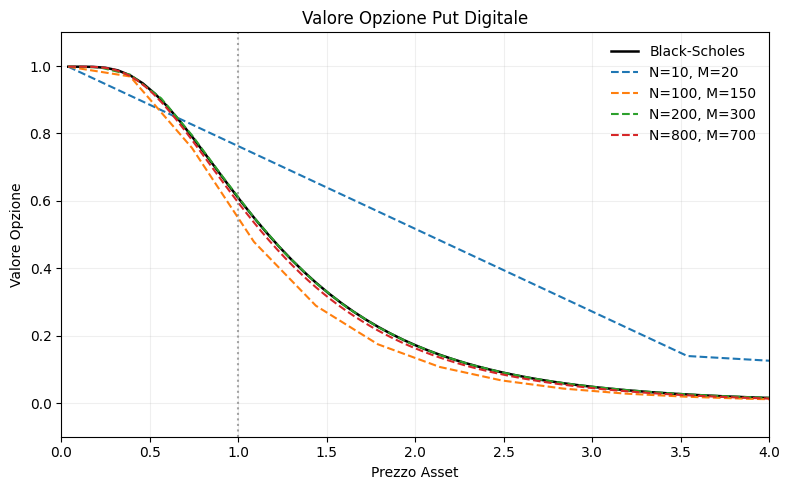

In [60]:
plt.figure(figsize=(8, 5))

#(Black-Scholes)
S_teorico = np.linspace(L, U, 500)
prezzo_teorico = np.exp(-r*T)*norm.cdf(-d2(S_teorico, k, r, T, sigma))
plt.plot(S_teorico, prezzo_teorico, 'k-', lw = 1.8, label='Black-Scholes')

# Soluzioni numeriche
for i, (n, m) in enumerate(zip(N, M)):
    plt.plot(S[i], D_EI_multi_t[i], '--', lw = 1.5, 
             label=f'N={n}, M={m}')

plt.axvline(k, color='grey', linestyle=':', alpha=0.7)
plt.title('Valore Opzione Put Digitale')
plt.xlabel('Prezzo Asset')
plt.ylabel('Valore Opzione')
plt.xlim(0, 4)
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper right', frameon=False)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [61]:
#Price interpolation
for i in range(len(N)): 
    S[i] = S[i].flatten() # trasforma in vettore 1D
D_EI_multi_t1 = D_EI_multi_t1.flatten()
D_EI_multi_t2 = D_EI_multi_t2.flatten()
D_EI_multi_t3 = D_EI_multi_t3.flatten()
D_EI_multi_t4 = D_EI_multi_t4.flatten()
Price1 = np.interp(S0,S[0],D_EI_multi_t1)
Price2 = np.interp(S0,S[1],D_EI_multi_t2)
Price3 = np.interp(S0,S[2],D_EI_multi_t3)
Price4 = np.interp(S0,S[3],D_EI_multi_t4)

print(Price1,Price2,Price3,Price4)


0.7623135740649176 0.5490586793324921 0.611099437340433 0.5948195672879643


### RMSE
This code computes the **Root Mean Square Error (RMSE)** between numerical option prices (from the Implicit Euler method) and analytical Black-Scholes solutions.

In [62]:
def compute_rmse(numerical_prices, grid_points, K, r, T, sigma):
    # Calcolo prezzi teorici
    d2_bs = (np.log(grid_points/K) + (r - 0.5*sigma**2)*T)
    d2_bs /= (sigma*np.sqrt(T))
    bs_prices = np.exp(-r*T)*norm.cdf(-d2_bs)
    
    # Calcolo RMSE
    return np.sqrt(np.mean((numerical_prices.flatten() - bs_prices)**2))

for i in range(len(N)):
    rmse = compute_rmse(D_EI_multi_t[i], S[i].flatten(), k, r, T, sigma)
    print(f"Grid {i+1}: N={N[i]}, M={M[i]} | RMSE = {rmse:.6f}")

Grid 1: N=10, M=20 | RMSE = 0.036050
Grid 2: N=100, M=150 | RMSE = 0.012610
Grid 3: N=200, M=300 | RMSE = 0.000498
Grid 4: N=800, M=700 | RMSE = 0.002778


### Function `theta_M`

This function implements the **Theta Method** for solving the Black-Scholes equation using an implicit discretization.  
In particular, when $\theta = 0.5$, it corresponds to the **Crank-Nicholson scheme**.  
The method builds two tridiagonal matrices $ A_T $ and $ B_T $, which are used to iteratively update the option price.

The matrix $ A_T $ has the following structure:  


$$A_T = 
\begin{bmatrix} 
1      & 0      & 0      & \ldots & 0      \\ 
a_1    & b_1    & c_1    & \ldots & 0      \\ 
0      & a_2    & b_2    & c_2    & \ldots \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
0      & \ldots & 0      & 0      & 1 
\end{bmatrix}$$


Where the coefficients are defined as:  

$$
a_i = (1 - \theta) \left( -\frac{r S_i}{2 dS} + \frac{\sigma^2 S_i^2}{2 dS^2} \right)
$$
$$
b_i = -\frac{1}{dt} + (1 - \theta) \left( -\frac{\sigma^2 S_i^2}{dS^2} - r \right)
$$
$$
c_i = (1 - \theta) \left( \frac{r S_i}{2 dS} + \frac{\sigma^2 S_i^2}{2 dS^2} \right)
$$

The matrix $ B_T $ has the same structure as $ A_T $, but with the coefficients multiplied by $-\theta$:  

$$
B_T = 
\begin{bmatrix} 
1      & 0      & 0      & \ldots & 0      \\ 
\tilde{a}_1    & \tilde{b}_1    & \tilde{c}_1    & \ldots & 0      \\ 
0      & \tilde{a}_2    & \tilde{b}_2    & \tilde{c}_2    & \ldots \\ 
\vdots & \ddots & \ddots & \ddots & \vdots \\ 
0      & \ldots & 0      & 0      & 1 
\end{bmatrix}
$$

Where the coefficients are given by:  

$$
\tilde{a}_i = -\theta \left( -\frac{r S_i}{2 dS} + \frac{\sigma^2 S_i^2}{2 dS^2} \right)
$$
$$
\tilde{b}_i = -\frac{1}{dt} - \theta \left( -\frac{\sigma^2 S_i^2}{dS^2} - r \right)
$$
$$
\tilde{c}_i = -\theta \left( \frac{r S_i}{2 dS} + \frac{\sigma^2 S_i^2}{2 dS^2} \right)
$$

In [63]:
def theta_M(theta,N,S,dS,r,sigma,dt):
    
    mA_T = np.zeros((N+1,N+1))
    mA_T[0,0]=1
    for i in range(1,N):
        mA_T[i,i-1] = (1-theta)*( -r*S[i]/(2*dS)+sigma**2/2*(S[i]**2)/(dS**2) )
        mA_T[i,i] = -1/dt+(1-theta)*( -sigma**2*(S[i]**2)/(dS**2)-r )
        mA_T[i,i+1] = (1-theta)*( r*S[i]/(2*dS)+sigma**2/2*(S[i]**2)/(dS**2) )
    mA_T[N,N]=1

    mB_T = np.zeros((N+1,N+1))
    for i in range(1,N):
        mB_T[i,i-1] = (-theta)*( -r*S[i]/(2*dS)+sigma**2/2*(S[i]**2)/(dS**2) )
        mB_T[i,i] = -1/dt+(-theta)*( -sigma**2*(S[i]**2)/(dS**2)-r )
        mB_T[i,i+1] = (-theta)*( r*S[i]/(2*dS)+sigma**2/2*(S[i]**2)/(dS**2) )
    return mA_T,mB_T

### Backward Time Procedure with Theta Method

This section of code applies the **Theta Method** to solve the Black-Scholes equation by iterating backward in time. The key function involved is `rhs_theta_M`, which computes the **right-hand side (RHS)** of the linear system for each time step, using the matrix \( B_T \) constructed in the `theta_M` function.

#### Key Steps:
- **Boundary Conditions:**  
  Depending on the `flagPUT` parameter, the boundary conditions \( BC_0 \) and \( BC_N \) are set to either \( e^{-r (T - t)} \) or 0, representing the payoff at the boundaries.

- **RHS Computation:**  
  For each time step, the RHS is computed by the matrix-vector product:
  $$
  \text{rhs} = B_T \cdot D
  $$
  After this computation, the boundary conditions are imposed directly on the first and last elements of the RHS vector.

- **Time Marching and Role of Temporary Variables:**  
  For each grid resolution, the code iterates over the time steps to update the option price backward in time:
  - **Initialization:**  
    A temporary variable (e.g., `temp1`, `temp2`, etc.) is initialized with the payoff at maturity. This vector represents the option's value at the final time.
  - **Backward Iteration:**  
    At each time step:
    - The RHS is recalculated using `rhs_theta_M` with the current solution vector.
    - The linear system
      $$
      A_T \cdot D = \text{rhs}
      $$
      is solved (using `np.linalg.solve`) to update the solution.
    - The temporary variable is updated with the new solution, effectively marching the solution backward from maturity to \( t=0 \).
  - **Final Output:**  
    After completing all time steps, the final solution (i.e., the option price at \( t=0 \)) is stored as `D_TM1`, `D_TM2`, `D_TM3`, or `D_TM4` for different grid resolutions.

#### Outputs:
- `D_TM1`, `D_TM2`, `D_TM3`, and `D_TM4` represent the option prices computed at different grid resolutions.
- These solutions are collected into the list `D_TM` for further comparison or plotting.

This approach captures the evolution of the option price over time while ensuring stability through the Theta Method. The temporary variables play a crucial role in maintaining the state of the solution as it is updated at each time step.


In [64]:
# procedere backward in time
def rhs_theta_M(mB_T,N,M,dt,T,D,flagPUT=0):
    rhs = np.zeros((N+1,1))
    for j in (M,0,-1):
        t = (j-1)*dt
        if flagPUT == 0:
            BC0 = mt.exp(-r*(T-t))
            BCN = 0
        else:
            BC0 = 0
            BCN = mt.exp(-r*(T-t))
            # ricostruire rhs (right-hand-side, termine noto del sistema lineare)
        rhs = np.matmul(mB_T,D)
        rhs[0] = BC0
        rhs[N] = BCN
    return rhs

D = D_
S = S_
theta = 0.3
mA_TM1, mB_TM1 = theta_M(theta, N[0], S[0], dS[0], r, sigma, dt[0])
temp1 = D[0].copy()
for j in range(M[0]):
    rhs_TM1 = rhs_theta_M(mB_TM1, N[0], 1, dt[0], T, temp1)
    temp1 = np.linalg.solve(mA_TM1, rhs_TM1)
D_TM1 = temp1

mA_TM2, mB_TM2 = theta_M(theta, N[1], S[1], dS[1], r, sigma, dt[1])
temp2 = D[1].copy()
for j in range(M[1]):
    rhs_TM2 = rhs_theta_M(mB_TM2, N[1], 1, dt[1], T, temp2)
    temp2 = np.linalg.solve(mA_TM2, rhs_TM2)
D_TM2 = temp2

mA_TM3, mB_TM3 = theta_M(theta, N[2], S[2], dS[2], r, sigma, dt[2])
temp3 = D[2].copy()
for j in range(M[2]):
    rhs_TM3 = rhs_theta_M(mB_TM3, N[2], 1, dt[2], T, temp3)
    temp3 = np.linalg.solve(mA_TM3, rhs_TM3)
D_TM3 = temp3

mA_TM4, mB_TM4 = theta_M(theta, N[3], S[3], dS[3], r, sigma, dt[3])
temp4 = D[3].copy()
for j in range(M[3]):
    rhs_TM4 = rhs_theta_M(mB_TM4, N[3], 1, dt[3], T, temp4)
    temp4 = np.linalg.solve(mA_TM4, rhs_TM4)
D_TM4 = temp4

D_TM = [D_TM1,D_TM2,D_TM3,D_TM4]

/var/folders/ql/7zw0844j5_jcx423pd0sctvh0000gn/T/ipykernel_5170/2272223492.py:5: RuntimeWarning: divide by zero encountered in log
  return (np.log(S/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))


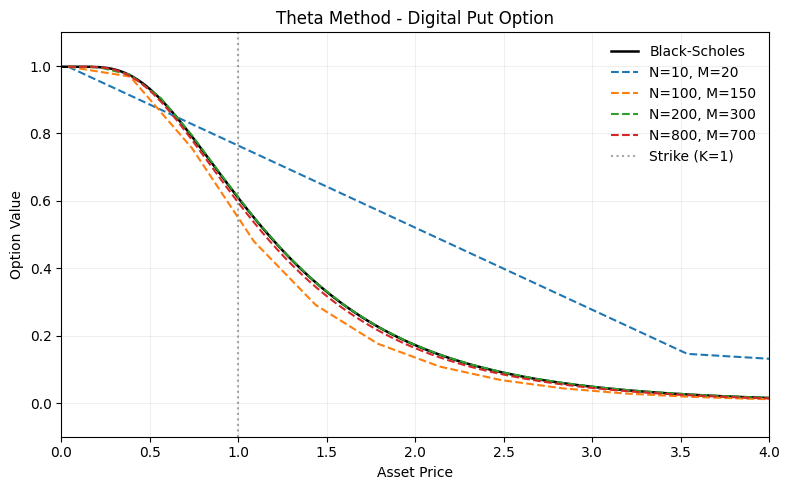

In [65]:
plt.figure(figsize=(8, 5))

# Calcola e plotta soluzione teorica Black-Scholes
S_teorico = np.linspace(0, 4, 500)
prezzo_teorico = np.exp(-r*T)*norm.cdf(-d2(S_teorico, k, r, T, sigma))
plt.plot(S_teorico, prezzo_teorico, 'k-', lw = 1.8, label='Black-Scholes')

# Plot soluzioni numeriche
for i, (n, m) in enumerate(zip(N, M)):
    plt.plot(S[i], eval(f'D_TM{i+1}'), '--', lw=1.5, 
             label=f'N={n}, M={m}')

plt.axvline(k, color='grey', linestyle=':', alpha=0.7, label=f'Strike (K={k})')
plt.title('Theta Method - Digital Put Option')
plt.xlabel('Asset Price')
plt.ylabel('Option Value')
plt.xlim(0, 4)
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper right', frameon=False)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [66]:
D_TM1 = D_TM1.flatten()
D_TM2 = D_TM2.flatten()
D_TM3 = D_TM3.flatten()
D_TM4 = D_TM4.flatten()
Price1 = np.interp(S0,S[0],D_TM1)
Price2 = np.interp(S0,S[1],D_TM2)
Price3 = np.interp(S0,S[2],D_TM3)
Price4 = np.interp(S0,S[3],D_TM4)

print(Price1,Price2,Price3,Price4)

0.7639084937299181 0.5498096642159074 0.6112916581938295 0.5949343770051044


In [67]:
for i in range(len(N)):
    rmse = compute_rmse(D_TM[i], S[i].flatten(), k, r, T, sigma)
    print(f"Grid {i+1}: N={N[i]}, M={M[i]} | RMSE = {rmse:.6f}")

Grid 1: N=10, M=20 | RMSE = 0.038101
Grid 2: N=100, M=150 | RMSE = 0.012348
Grid 3: N=200, M=300 | RMSE = 0.000457
Grid 4: N=800, M=700 | RMSE = 0.002697
